# Description of the data

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://debatabat.dk/wp-content/uploads/2016/06/airbnb-logo.png")

In [2]:
%matplotlib inline

##  Why Airbnb?

Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present a more unique, personalized way of experiencing the world. 
Today Airbnb became a kind of service that is used and recognized by the whole world. Data analysis on thousands of listings provided through Airbnb is important for the company, these listings generate a lot of data which can be analyzed, that's also the reason why I would like to dig deeper into this topic.

The dataset is downloaded from http://insideairbnb.com/, it describes the listing activity and metrics in Copenhagen for 2022.

##  Why Copenhagen?

Tripadvisor shows that Copenhagen is among Best & Most Beautiful Cities in Europe to Visit in 2022.

Before the pandemic situation hit the global tourism industry. The Airbnb grow rapidly in Copenagen and generated a highly comprehensive data within Northern Europe.

##  Resarch areas

The properties have large differences in prices, the most interesting variables regarding price prediction are:
- location
- room type
- host listings count
- number of reviews

Besides basic data wrangling and plots, the interactive Folium maps, interactive plotly graphs and text mining of the review comments are added as well.

##  Loading libraries and data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from re import sub
from decimal import Decimal
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gp
from branca.colormap import LinearColormap

In [4]:
#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as ply
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [5]:
data_listings = pd.read_csv('C:/Users/QiWang/Downloads/listings.csv', index_col='id')
data_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 6983 to 49004551
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   10250 non-null  object 
 1   scrape_id                                     10250 non-null  int64  
 2   last_scraped                                  10250 non-null  object 
 3   name                                          10250 non-null  object 
 4   description                                   9928 non-null   object 
 5   neighborhood_overview                         5589 non-null   object 
 6   picture_url                                   10250 non-null  object 
 7   host_id                                       10250 non-null  int64  
 8   host_url                                      10250 non-null  object 
 9   host_name                                     10245 non

In [6]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate"]

In [7]:
listings_details = pd.read_csv('C:/Users/QiWang/Downloads/listings_details.csv', index_col='id')
listings_details.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [8]:
listings = pd.merge(listings_details,data_listings[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 6983 to 49004551
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            10250 non-null  object 
 1   host_id                         10250 non-null  int64  
 2   host_name                       10245 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   10250 non-null  object 
 5   latitude                        10250 non-null  float64
 6   longitude                       10250 non-null  float64
 7   room_type                       10250 non-null  object 
 8   price                           10250 non-null  int64  
 9   minimum_nights                  10250 non-null  int64  
 10  number_of_reviews               10250 non-null  int64  
 11  last_review                     8697 non-null   object 
 12  reviews_per_month         

In [9]:
#listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))
listings.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate
id,,,,,,,,,,,,,,,,,,,,,
6983,Copenhagen 'N Livin',16774,Simon,NaN,Nrrebro,55.686410,12.547410,Entire home/apt,717,2,...,4.78,4.90,4.87,4.78,15,https://www.airbnb.com/rooms/6983,f,"I'm currently working as an environmental consultant for a large engineering consultancy in Copenhagen.\r\nWhen I'm not at work, I spend time doing sports (playing football, running, cross fit), or doing indoor activities such as reading books and listening to music. I have recently taken an interest in cooking, and I love great food. \r\nI'm outgoing, happy and love good company.\r\nAnd I love my bike as any other person from Copenhagen..",a few days or more,0.0
26057,Lovely house - most attractive area,109777,Kari,NaN,Indre By,55.693071,12.576494,Entire home/apt,2400,4,...,4.92,4.85,4.92,4.91,1125,https://www.airbnb.com/rooms/26057,f,"We are a family with 2 children, and living in a great and beautiful house placed in a very special part in central Copenhagen called Kartoffelraekkerne. It's like a small village in the center of the city! The house is available from time to time - when we are travelling/working abroad. We're looking forward to hearing from you.",within a day,90.0
31094,"Very central and cozy, new kitchen",129976,Ebbe,NaN,Vesterbro-Kongens Enghave,55.665390,12.556390,Entire home/apt,750,2,...,4.80,4.80,4.85,4.87,10,https://www.airbnb.com/rooms/31094,f,"Hi and welcome. My name is Ebbe, I am a medical doctor working in Copenhagen. I live in the flat with my girlfriend Lea who is working as a nurse. \r\n\r\nWe love sports, music and travelling, and we look forward welcoming you to CPH",NaN,NaN
32379,"165 m2 artist flat on Vesterbro, with 2 bathrooms",140105,Lise,NaN,Vesterbro-Kongens Enghave,55.672638,12.552493,Entire home/apt,1153,3,...,4.96,4.90,4.87,4.90,365,https://www.airbnb.com/rooms/32379,t,"As profession - Set and Costumedesigner for Avangarde Theatre, Modern Dance and Performance. A traveler, enjoy to se the whole world, meet people and talk about the world situation",within an hour,100.0
32841,Cozy flat for Adults/Quiet for kids,142143,Anders & Maria,NaN,sterbro,55.711760,12.570910,Entire home/apt,617,100,...,4.75,5.00,5.00,4.57,1125,https://www.airbnb.com/rooms/32841,f,"Anders:\r\nHitchhiked 100.000 km's, Been publicly speaking more than 500 times, Traveled 80 countries, Lived 36 yrs. Have 7 sisters and brothers, Twins, 1 wife... and a million plans!\r\nMaria:\r\nSinger/nurse/Twin-Mum/training to be a midwife. Lived 6 years in London and toured the world with a British Pop band…including an appearance at the Bollywood Awards:-)",NaN,NaN


In [10]:
data_calendar = pd.read_csv('C:/Users/QiWang/Downloads/calendar.csv',parse_dates=['date'],index_col='listing_id')
data_calendar

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
1206018,2022-03-29,f,$550.00,$550.00,4.0,15.0
1206018,2022-03-30,f,$550.00,$550.00,4.0,15.0
1206018,2022-03-31,f,$550.00,$550.00,4.0,15.0
1206018,2022-04-01,f,$550.00,$550.00,4.0,15.0
1206018,2022-04-02,f,$550.00,$550.00,4.0,15.0
...,...,...,...,...,...,...
1366429,2023-03-25,f,"$1,800.00","$1,800.00",3.0,1125.0
1366429,2023-03-26,f,"$1,800.00","$1,800.00",3.0,1125.0
1366429,2023-03-27,f,"$1,800.00","$1,800.00",3.0,1125.0


In [11]:
reviews_details = pd.read_csv('C:/Users/QiWang/Downloads/reviews.csv',parse_dates=['date'])
reviews_details

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6983,8985,2009-09-04,31133,Jeff,"Convenient location, clean apartment, great breakfast...couldn't have asked for more. Best value in lodging in all of Copenhagen."
1,6983,9199,2009-09-07,11472,Andrea,We really enjoyed staying to Simon in our first visit to Copenhagen.\r<br/>His place his good located and very confortable.\r<br/>Good host and lovely breakfast in the morning.\r<br/>
2,6983,11763,2009-09-28,35317,Jeanine,"Friendly host, save neighbourhood, clean appartment and comfortable bed: I enjoyed it very much!"
3,6983,20616,2009-12-17,53151,Sonja,"Simon is great! Fantastic place to stay, super organized and friendly host and a comfortable bed, what more could you ask?"
4,6983,23168,2010-01-04,50856,James,"Great bed, clean apartment, comfy bed, accomodating host, great price. Can't ask for more!"
...,...,...,...,...,...,...
201059,583961518321668862,591852433974743583,2022-03-27,309588253,Austin,Emil's place was very clean and cozy. placed in a great spot in Copenhagen. Check-in/check-out was painless and easy!
201060,588069988857678577,591804976368693669,2022-03-27,135225,Cecilie,"I stayed with my family, me, my partner and Eira (8 months). We had a beautiful stay, super neighborhood, lovely backyard with great playing opportunities for kids and a great value for the appartement. Emil is a great host, good communication and service. We would love to come back."
201061,588279832225880383,591822651896598198,2022-03-27,237134072,Jacob,Super dejlig lejlighed <br/>Pænt og rent <br/>Lækker altan med hyggelige møbler . <br/>Tæt på vandet og alt muligt andet . <br/>Nem parkering og jeg kunne blive ved 😊<br/>Altså super vært 👍
201062,589006014594795287,591111399808162130,2022-03-26,451087843,Julia,"it’s was very clean and comfortable bed, emma was a nice person and you can talk to her about everything and she was a really good host👍🏼"


In [12]:
#data_listings['price'].dtype

In [13]:
#data_listings['price'] = (data_listings['price'].str.strip('00')).str.replace('[\$\,\.]', '').astype(int)
#data_listings['price'].str.strip( '00' )

In [14]:
#data_listings['price'].head()

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 6983 to 49004551
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            10250 non-null  object 
 1   host_id                         10250 non-null  int64  
 2   host_name                       10245 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   10250 non-null  object 
 5   latitude                        10250 non-null  float64
 6   longitude                       10250 non-null  float64
 7   room_type                       10250 non-null  object 
 8   price                           10250 non-null  int64  
 9   minimum_nights                  10250 non-null  int64  
 10  number_of_reviews               10250 non-null  int64  
 11  last_review                     8697 non-null   object 
 12  reviews_per_month         

In [16]:
#neighbourhood = pd.read_csv('C:/Users/QiWang/Downloads/neighbourhoods.csv')
#neighbourhood.info()

In [17]:
listings['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [18]:
listings.isnull().sum()

name                                  0
host_id                               0
host_name                             5
neighbourhood_group               10250
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        1553
reviews_per_month                  1553
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           10250
property_type                         0
accommodates                          0
first_review                       1553
review_scores_value                1621
review_scores_cleanliness          1621
review_scores_location             1621
review_scores_accuracy             1621
review_scores_communication        1620


In [19]:
#data_listings.drop(['id','host_name','last_review'],axis=1,inplace=True)
#data_listings.head()

In [20]:
#data_listings['reviews_per_month'].fillna(0,inplace=True)

In [21]:
listings['price'].describe()

count     10250.000000
mean       1125.254829
std        2295.387877
min           0.000000
25%         650.000000
50%         899.000000
75%        1200.000000
max      100000.000000
Name: price, dtype: float64

In [22]:
(listings[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
 .describe())

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,10250.000000,10250.000000,10250.000000,8697.000000,10250.000000,10250.000000
mean,1125.254829,4.683512,19.616000,0.622190,5.325463,85.699805
std,2295.387877,18.415440,37.260139,0.856332,22.644004,113.792660
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,650.000000,2.000000,2.000000,0.170000,1.000000,0.000000
50%,899.000000,3.000000,8.000000,0.360000,1.000000,23.000000
75%,1200.000000,4.000000,22.000000,0.750000,1.000000,146.000000
max,100000.000000,1111.000000,678.000000,17.750000,166.000000,365.000000


In [23]:
listings1 = listings.loc[listings['price']>0]
listings1.describe()

,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,accommodates,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,host_response_rate
count,1.024700e+04,0.0,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,8696.000000,10247.000000,10247.000000,...,10247.000000,8628.000000,8628.000000,8628.000000,8628.000000,8629.000000,8629.000000,8696.000000,10247.000000,6780.000000
mean,9.114068e+07,NaN,55.679722,12.559248,1125.584269,4.684591,19.621353,0.622206,5.326730,85.724895,...,3.418269,4.711198,4.688656,4.819320,4.834882,4.899644,4.882854,4.749427,534.997463,89.742183
std,1.120796e+08,NaN,0.019861,0.032005,2295.643123,18.418028,37.264266,0.856380,22.647198,113.799868,...,1.760424,0.345182,0.416390,0.269287,0.304753,0.271271,0.263742,0.525483,527.046056,24.476961
min,1.171800e+04,NaN,55.615190,12.447650,75.000000,1.000000,0.000000,0.010000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,1.160118e+07,NaN,55.666110,12.542100,650.000000,2.000000,2.000000,0.170000,1.000000,0.000000,...,2.000000,4.610000,4.560000,4.750000,4.790000,4.900000,4.860000,4.690000,20.000000,98.000000
50%,3.916108e+07,NaN,55.680330,12.556980,899.000000,3.000000,8.000000,0.360000,1.000000,23.000000,...,3.000000,4.770000,4.810000,4.900000,4.920000,5.000000,4.970000,4.880000,365.000000,100.000000
75%,1.377294e+08,NaN,55.694476,12.581145,1200.000000,4.000000,22.000000,0.750000,1.000000,146.000000,...,4.000000,4.940000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1125.000000,100.000000
max,4.513133e+08,NaN,55.735990,12.639720,100000.000000,1111.000000,678.000000,17.750000,166.000000,365.000000,...,16.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4000.000000,100.000000


In [24]:
top_host_id = listings['host_id'].value_counts().head(10)
top_host_id

187610263    166
155348640     79
437864658     64
325502105     55
179753578     25
3366007       15
244829847     13
2806924       12
201720555     12
164771007     11
Name: host_id, dtype: int64

In [39]:
#sns.set(rc={'figure.figsize':(10,8)})
#viz_bar = top_host_id.plot(kind='bar')
#viz_bar.set_title('Hosts with the most listings in Copenhagen')
#viz_bar.set_xlabel('Host ID')
#viz_bar.set_ylabel('Count of listnings')
#viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

In [26]:
labels = listings.neighbourhood.value_counts().index
labels

Index(['Vesterbro-Kongens Enghave', 'Indre By', 'Nrrebro', 'sterbro',
       'Frederiksberg', 'Amager Vest', 'Amager st', 'Valby', 'Bispebjerg',
       'Vanlse', 'Brnshj-Husum'],
      dtype='object')

# Data exploration

## Neighbourhoods

Neighbourhood "Vesterbro-Kongens Enghave" holds most listings, and five neighbourhoods have over one thousands listings.

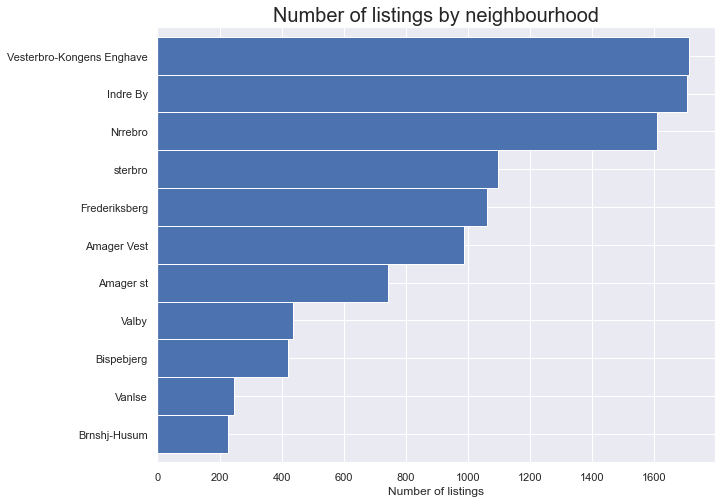

In [27]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

Below we can see that most listings are in the city center, it is an interactive map, and we can zoom-in on the clusters to find the individual locations of the listinigs.


In [28]:
latitude2022 = listings['latitude'].tolist()
longitude2022 = listings['longitude'].tolist()
locations = list(zip(latitude2022,longitude2022))

map1 = folium.Map(location=[ 55.679722,12.559248], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

##  Room types and property types

### Room types

The room type is very important in Copenhagen, because Airbnb has signed a collaboration agreement with the Danish Tax Authority to ensure hosts on Airbnb can share their homes responsibly and enjoy new benefits: Hosts can share primary entire homes for 70 nights a year (can be increased by municipalities to 100 nights) .

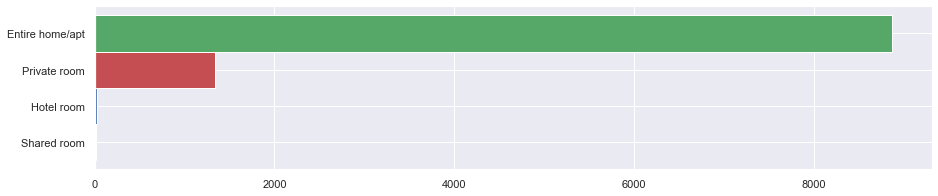

In [29]:
freq = listings['room_type'].value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15,3), width=1, color = ["g", "b", "r"])
plt.show()

### Property types

In [30]:
listings.property_type.unique()

array(['Entire rental unit', 'Entire residential home',
       'Private room in rental unit', 'Entire condominium (condo)',
       'Private room in condominium (condo)', 'Entire loft',
       'Private room in condo', 'Shared room in rental unit',
       'Private room in home', 'Entire home', 'Entire villa',
       'Entire condo', 'Entire townhouse', 'Houseboat',
       'Private room in residential home', 'Private room in loft',
       'Entire bungalow', 'Private room in guest suite',
       'Private room in townhouse', 'Entire serviced apartment', 'Boat',
       'Private room in bed and breakfast', 'Private room in guesthouse',
       'Private room in villa', 'Entire guesthouse', 'Room in hostel',
       'Barn', 'Shared room in cabin', 'Entire cabin',
       'Shared room in loft', 'Tiny home',
       'Private room in serviced apartment', 'Private room in bungalow',
       'Entire cottage', 'Private room', 'Entire guest suite',
       'Room in boutique hotel', 'Room in serviced apartmen

In [31]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop

room_type,Entire home/apt,Hotel room,Private room,Shared room
property_type,,,,
Entire loft,119.0,NaN,NaN,NaN
Private room in condo,NaN,NaN,127.0,NaN
Entire residential home,139.0,NaN,NaN,NaN
Entire townhouse,226.0,NaN,NaN,NaN
Entire serviced apartment,278.0,NaN,NaN,NaN
Entire home,354.0,NaN,NaN,NaN
Entire condominium (condo),852.0,NaN,NaN,NaN
Private room in rental unit,NaN,NaN,870.0,NaN
Entire condo,1074.0,NaN,NaN,NaN


As we can see, the majority of the properties in Copenhagen is apartment(5641)

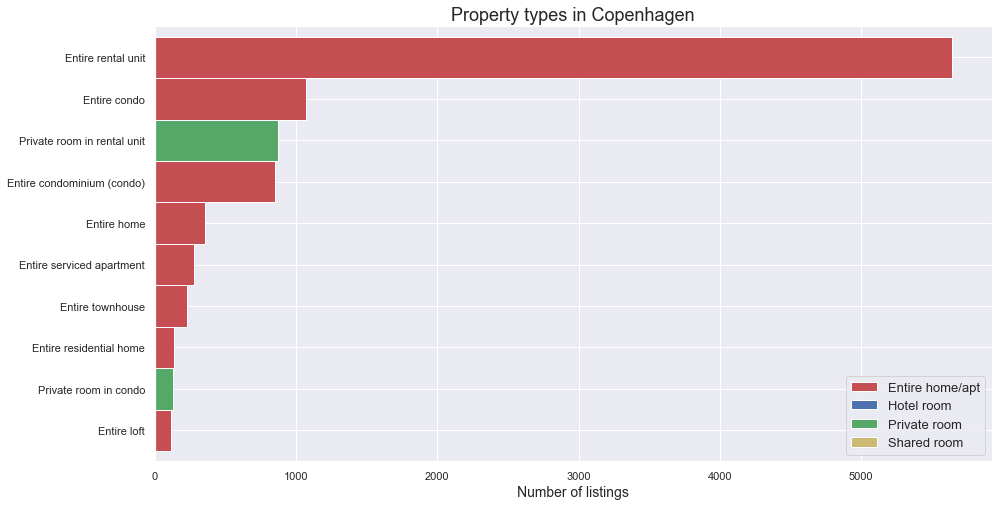

In [32]:
prop.plot(kind='barh',stacked=True, color = ["r","b","g","y"],linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Copenhagen', fontsize=18)
plt.xlabel('Number of listings',fontsize=14)
plt.ylabel("")
plt.legend(loc = 4, prop = {"size": 13})
plt.rc('ytick', labelsize=13)
plt.show()

## Accommodates (number of people)

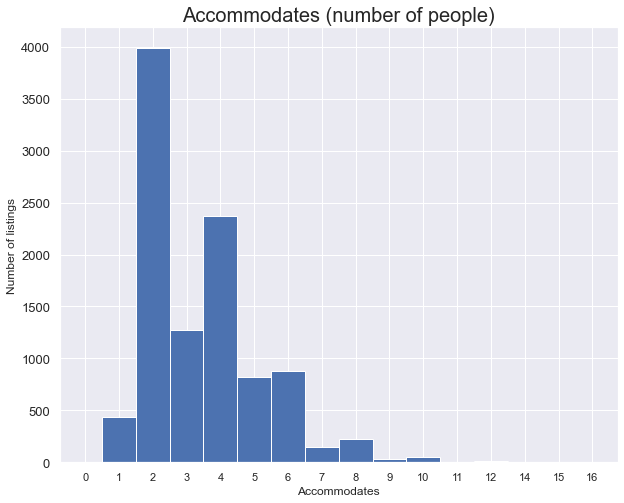

In [33]:
feq1=listings['accommodates'].value_counts().sort_index()
feq1.plot.bar(figsize=(10,8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

In [34]:
private = listings[data_listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id','host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,private_rooms
932,164771007,Reception,11
509,31867239,Simon,7
1091,342326987,SleepCph,6
314,14245180,Guillaume,6
1,112210,Julia,5


In [35]:
freq = listings.groupby(['host_id','host_name','host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'],ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
4331,187610263,ApartmentinCopenhagen,"Vi udlejer møblerede lejligheder og har mere end 10 års erfaring. \r\nVores mission er at udleje fuldt møblerede lejligheder og hotellejligheder med de bedste beliggenheder i København til turister, forretningsrejsende, virksomheder og deres medarbejdere. Vi er til stede i København og står til rådighed 24/7 for vore gæster og ejere.",166
4715,437864658,Sanders,Sanders provides quality stays around the world with a hotel-like service done better.,64
4619,325502105,Hotel Apartments Copenhagen,"Hi There,\nWe are HAC, formally known as Hotel Apartments Copenhagen. HAC provides rental apartments in central Copenhagen. \n\nWe offer comfort over practicality! Renting one of our hotel apartments instead of an ordinary hotelroom will not only give you much more space, but also much more comfort\n\nWe offer apartments where you can feel at home! Each apartment has a fully equipped kitchen, ready to cook a nice meal. \n\nAre you also tired you living out of your suitcase when staying at hotels? Book one of our apartments, and experience a home away from home like nowhere else.\n\n\nWe typically respond to our guests within 10 minutes. \n\nOur availability over phone is as follows: \nMonday: 9am - 5pm\nTuesday: 9am - 5pm\nWednesday : 9am - 5pm\nThursday : 9am - 5pm Friday : 9am - 5pm\nSaturday : 3pm - 5pm\nSunday : 3pm - 5pm\n\nBest, \nHotel Apartments Copenhagen.",55
4293,179753578,Rent A Place,"Rent A Place, has apartments on the best locations primary in Inner City of Copenhagen. We are only located in the center of the center and sights, shopping or metro is just a small walk away. . \n\nAre you looking for prime locations, cosy interiors and attentive service? \nWe’re here to give you a welcoming & local experience in Copenhagen.\n \nAll of our apartments has fast wifi and complimentary in-room service. \n\nSo if you are looking for a comfortable place that lets you do more than just sleep, we are here to help.\n\nMaking you feel at home and otherwise staying out of your way, is our top priority. By preparing everything ahead of time, you and your travel companions will enjoy the privacy and flexibility during your visit. \n\nCheck in to your many of our apartments at your own with your own passcode. \n‍\nIf you need us during your stay, are we always a sms away.\n\nRent A Place",25


# Advice to the tourists

##  Average daily price per neighbourhood

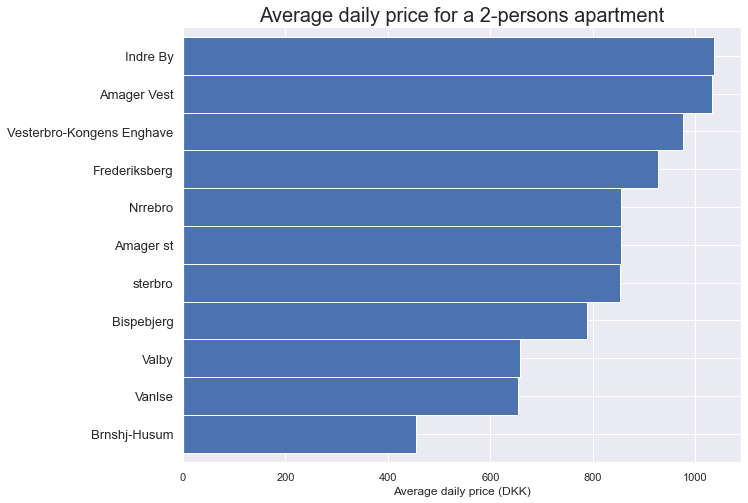

In [36]:
freq1 = listings[data_listings['accommodates'] == 2]
freq1 = freq1.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
freq1.plot.barh(figsize=(10,8), color='b', width=1)
plt.title('Average daily price for a 2-persons apartment',fontsize=20)
plt.xlabel('Average daily price (DKK)', fontsize=12)
plt.ylabel("")
plt.show()

In [37]:
#freq1 = pd.DataFrame([freq1])
freq1 = freq1.transpose()
freq1

neighbourhood
Brnshj-Husum                  455.566667
Vanlse                        654.204819
Valby                         657.443662
Bispebjerg                    788.128205
sterbro                       851.836364
Amager st                     853.973154
Nrrebro                       854.621110
Frederiksberg                 927.022785
Vesterbro-Kongens Enghave     976.313117
Amager Vest                  1031.352201
Indre By                     1036.953947
Name: price, dtype: float64

In [40]:
adam = gp.read_file("C:/Users/QiWang/Downloads/neighbourhoods.geojson")
#freq1 = pd.DataFrame([freq1])
#freq1 = freq1.transpose()
adam = pd.merge(adam, freq1, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[55.679722,12.559248], zoom_start=11)
folium.GeoJson(data=adam,
               name='Copenhagen',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

##  Finding a good host

At Airbnb there is a status "Superhost". From Airbnb it says that:

- As a Superhost, you’ll have more visibility, earning potential, and exclusive rewards. It's our way of saying thank you for your outstanding hospitality.
- How to become a Superhost: Every 3 months, we check if you meet the following criteria. If you do, you'll earn or keep your Superhost status.
    - Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year.
    - Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays.
    - Superhosts have no cancellations in the past year, unless there were extenuating circumstances.
    -Superhosts respond to 90% of new messages within 24 hours.

Below, we can see that only a small portion of the listings in Copenhagen is Superhost.

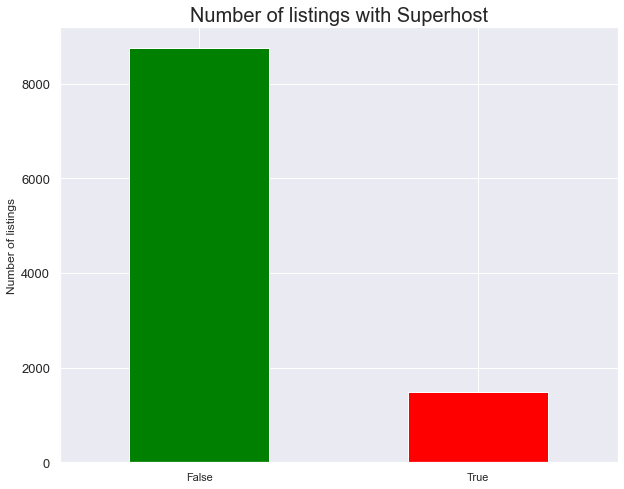

In [41]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t":"True", "f":"False"})

freq2 = listings['host_is_superhost'].value_counts()
freq2.plot.bar(figsize=(10,8), width=0.5, rot=0, color=["green", "red"])
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel("Number of listings", fontsize=12)
plt.show()

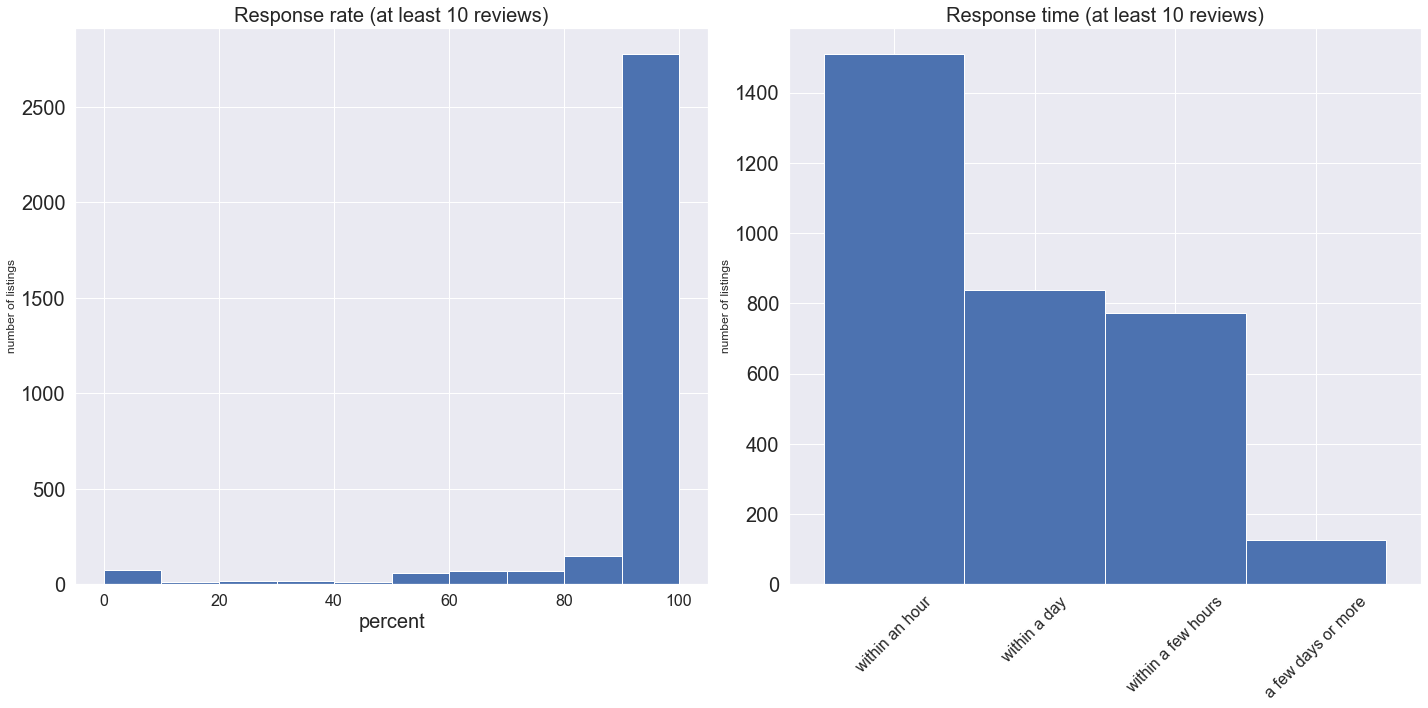

In [42]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
listings10 = listings[listings['number_of_reviews']>=10]
feq1 = listings10['host_response_rate'].dropna()
ax1 = plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent",fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2 = feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

##  Availability

The calendar file contains the file records the price, availability and other details from the listing's calendar for each day of the next 365 days.

In [43]:
data_calendar.price = data_calendar.price.str.replace(",","")

In [44]:
data_calendar['price'] = pd.to_numeric(data_calendar['price'].str.strip('$'))

In [45]:
data_calendar = data_calendar[data_calendar.date < '2023-03-29']
data_calendar

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
1206018,2022-03-29,f,550.0,$550.00,4.0,15.0
1206018,2022-03-30,f,550.0,$550.00,4.0,15.0
1206018,2022-03-31,f,550.0,$550.00,4.0,15.0
1206018,2022-04-01,f,550.0,$550.00,4.0,15.0
1206018,2022-04-02,f,550.0,$550.00,4.0,15.0
...,...,...,...,...,...,...
1366429,2023-03-24,f,1800.0,"$1,800.00",3.0,1125.0
1366429,2023-03-25,f,1800.0,"$1,800.00",3.0,1125.0
1366429,2023-03-26,f,1800.0,"$1,800.00",3.0,1125.0


In [46]:
print(data_calendar.shape)

(3736401, 6)


In [47]:
data_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3736401 entries, 1206018 to 1366429
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           float64       
 3   adjusted_price  object        
 4   minimum_nights  float64       
 5   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 199.5+ MB


In [49]:
#data_calendar1 = data_calendar[['listing_id','date','available','price']]
#data_calendar1

The calendar data is shown below. Availability means that whether the date is available for a booking, i.e. when the status is FALSE it means either the owner doesn't want to rent out the room on the specific date or the room has been booked for that date. 

In [52]:
listings.index.name = "listing_id"

In [53]:
calendar = pd.merge(data_calendar, listings[['accommodates']], on = 'listing_id', how = "left")
calendar.sample(15)

,date,available,price,adjusted_price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,,
32108991,2023-03-06,f,1000.0,"$1,000.00",5.0,1125.0,5
1714518,2023-03-25,t,895.0,$895.00,2.0,1125.0,3
18727579,2022-11-18,f,1195.0,"$1,195.00",4.0,21.0,4
39920494,2022-11-05,f,650.0,$650.00,1.0,1125.0,4
13097416,2023-01-04,f,1250.0,"$1,250.00",4.0,365.0,2
...,...,...,...,...,...,...,...
44408917,2022-04-04,t,1290.0,"$1,290.00",2.0,1125.0,5
46849416,2022-06-24,f,850.0,$850.00,3.0,1125.0,5
14697513,2022-04-21,f,418.0,$418.00,3.0,7.0,2


Now let's have a look at the number of available accomodations in the future. The graph is **interactive**, and hovering over the points will show you a tooltip with the number of available listings and date.

In [54]:
sum_available = data_calendar[data_calendar.available == 't'].groupby(['date']).size().to_frame(name = 'available').reset_index()
sum_available['date'] = pd.to_datetime(sum_available.date, errors='coerce')
sum_available['date']

0     2022-03-29
1     2022-03-30
2     2022-03-31
3     2022-04-01
4     2022-04-02
         ...    
360   2023-03-24
361   2023-03-25
362   2023-03-26
363   2023-03-27
364   2023-03-28
Name: date, Length: 365, dtype: datetime64[ns]

In [55]:
sum_available['weekday'] = sum_available['date'].apply(pd.to_datetime).dt.dayofweek
sum_available['weekday']

0      1
1      2
2      3
3      4
4      5
      ..
360    4
361    5
362    6
363    0
364    1
Name: weekday, Length: 365, dtype: int64

In [56]:
sum_available1 = sum_available.set_index('date')
sum_available1

,available,weekday
date,,
2022-03-29,351,1
2022-03-30,901,2
2022-03-31,1187,3
2022-04-01,1397,4
2022-04-02,1414,5
...,...,...
2023-03-24,3015,4
2023-03-25,3020,5
2023-03-26,3022,6


In [58]:
sum_available1.iplot(y='available',mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                    text = 'weekday', title = 'Number of listings available by date')

## Average price by date

The average price of all 2-persons accomodations flagged as available by date.

In [59]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price=average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
text='weekday', title='Average prie of available 2 persons accomodation by date')

# Text mining the Review comments

The reviews file holds 6 columns, we will merge the listing's host_id and host_names.

In [60]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]

In [61]:
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
8985,6983,Copenhagen 'N Livin',16774,Simon,2009-09-04,31133,Jeff,"Convenient location, clean apartment, great breakfast...couldn't have asked for more. Best value in lodging in all of Copenhagen."
9199,6983,Copenhagen 'N Livin',16774,Simon,2009-09-07,11472,Andrea,We really enjoyed staying to Simon in our first visit to Copenhagen.\r<br/>His place his good located and very confortable.\r<br/>Good host and lovely breakfast in the morning.\r<br/>
11763,6983,Copenhagen 'N Livin',16774,Simon,2009-09-28,35317,Jeanine,"Friendly host, save neighbourhood, clean appartment and comfortable bed: I enjoyed it very much!"
20616,6983,Copenhagen 'N Livin',16774,Simon,2009-12-17,53151,Sonja,"Simon is great! Fantastic place to stay, super organized and friendly host and a comfortable bed, what more could you ask?"
23168,6983,Copenhagen 'N Livin',16774,Simon,2010-01-04,50856,James,"Great bed, clean apartment, comfy bed, accomodating host, great price. Can't ask for more!"


Below you will find 5 most review hosts

In [62]:
host_reviews = reviews_details.groupby(['host_id','host_name']).size().sort_values(ascending=False).to_frame(name="number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
263601375,Copenhagen Downtown Hostel,1625
34105860,Den,1285
799887,Bente,1058
8602749,Myne,1043
2806924,Into This Place,1023


In [63]:
reviews_details.comments.head()

id
8985     Convenient location, clean apartment, great br...
9199     We really enjoyed staying to Simon in our firs...
11763    Friendly host, save neighbourhood, clean appar...
20616    Simon is great!  Fantastic place to stay, supe...
23168    Great bed, clean apartment, comfy bed, accomod...
Name: comments, dtype: object

In [66]:
reviews_details.comments.values[1]

'We really enjoyed staying to Simon in our first visit to Copenhagen.\r<br/>His place his good located and very confortable.\r<br/>Good host and lovely breakfast in the morning.\r<br/>'

In [68]:
#remove empty comments
reviews_details = reviews_details[reviews_details['comments'].notnull()]
reviews_details['comments'] = reviews_details['comments'].str.replace('\r<br/>', "")
#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#change to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")

#remove stopwords 
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

In [78]:
reviews_details.comments.values[1]

'really enjoyed staying simon first visit copenhagen his place good located confortable good host lovely breakfast morning '

In [74]:
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()
len(host_names)

2645

In [75]:
texts = reviews_details.comments.tolist()
vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns=['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
3,apartment,96069
437,br,94859
4,great,85655
35,stay,67854
20,place,65986
1,location,56599
77,nice,53832
12,copenhagen,51492
24,host,43700
91,us,40835


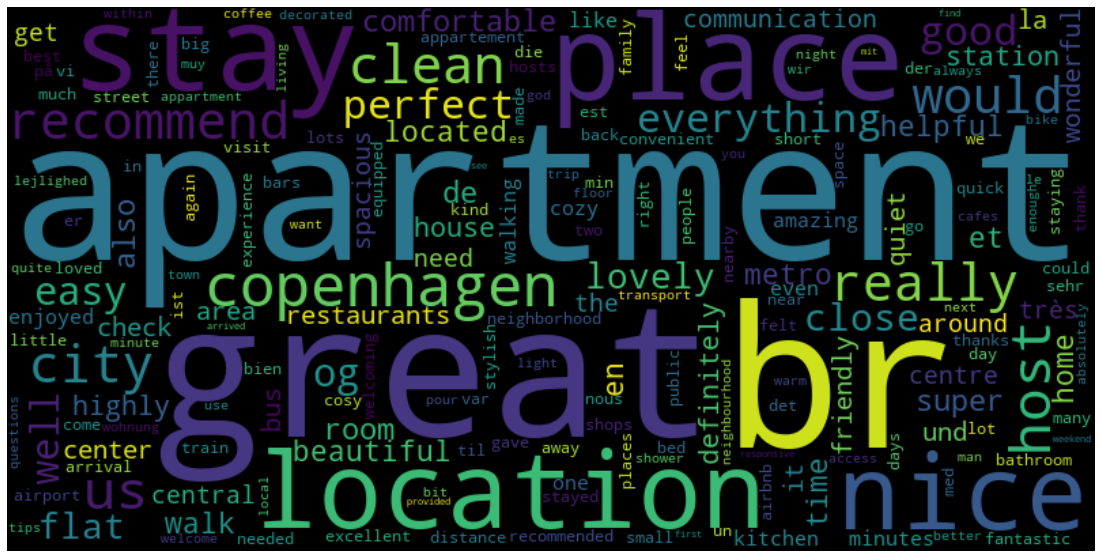

In [79]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()